# Машинное обучение в бизнесе
## Урок 3. Работа с признаками и селекция

In [37]:
import itertools
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
warnings.filterwarnings("ignore")

### Задание 1

Прочитайте базу `my_PJME_MW.csv` и сделайте ее перрасчет (ресемплинг) в представление по $1$ месяцу.

***Решение***

In [12]:
data = pd.read_csv(
    "../lesson02/my_PJME_MW.csv", index_col=[0], parse_dates=[0]
).sort_index()
data.head(3)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0


In [10]:
data_m = data[["PJME_MW", "year", "month", "quarter"]].resample("M").mean().sort_index()
data_m.head(3)

,PJME_MW,year,month,quarter
Date,,,,
2002-01-31,31075.399731,2002,1,1
2002-02-28,30239.166667,2002,2,1
2002-03-31,28875.256720,2002,3,1


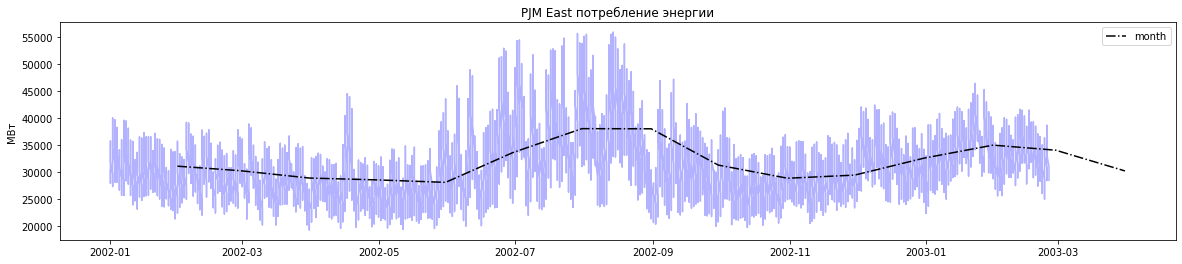

In [11]:
plt.figure(figsize=(20, 4))
plt.plot(
    data.index[: 5 * 24 * 7 * 4 * 3],
    data["PJME_MW"].values[: 5 * 24 * 7 * 4 * 3],
    "b",
    alpha=0.3,
)
plt.plot(data_m.index[: 5 * 3], data_m["PJME_MW"].values[: 5 * 3], "-.k", label="month")
plt.title("PJM East потребление энергии")
plt.ylabel("МВт")
plt.legend()
plt.show()

### Задание 2

Подберите параметры модели SARIMAX для этого ряда.

***Решение***

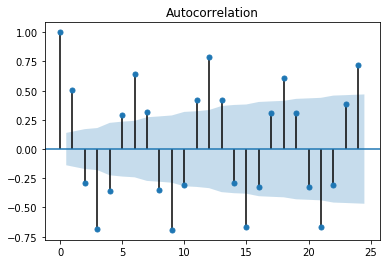

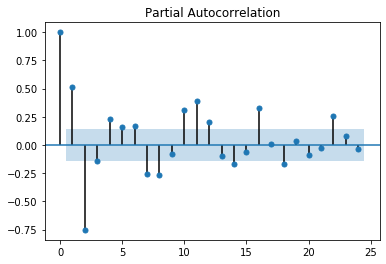

In [15]:
sm.graphics.tsa.plot_acf(data_m["PJME_MW"].values, lags=12 * 2)
plt.show()

sm.graphics.tsa.plot_pacf(data_m["PJME_MW"].values, lags=12 * 2)
plt.show()

In [30]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
# длина сезона 6 месяцев: зимой греем, летом кондиционируем и расход энергии примерно одинаковый
p = [0, 1]
d = [0, 1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print("Examples of parameter combinations for Seasonal ARIMA...")
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[0]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[0]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 0, 0, 6)
SARIMAX: (0, 0, 2) x (0, 0, 0, 6)
SARIMAX: (0, 0, 2) x (0, 0, 1, 6)


In [31]:
%%time

min_aic = None
arima_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                data_m["PJME_MW"].values,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )

            results = mod.fit()
            print("ARIMA{}x{} - AIC: {}".format(param, param_seasonal, results.aic))
            if not min_aic or min_aic > results.aic:
                min_aic = results.aic
                arima_params = "ARIMA{}x{} - AIC: {}".format(
                    param, param_seasonal, results.aic
                )
        except:
            continue

print("*" * 20)
print(arima_params)

ARIMA(0, 0, 0)x(0, 0, 0, 6) - AIC: 4699.195491264933
ARIMA(0, 0, 0)x(0, 0, 1, 6) - AIC: 4431.154940984645
ARIMA(0, 0, 0)x(0, 0, 2, 6) - AIC: 4211.398062904665
ARIMA(0, 0, 0)x(0, 1, 0, 6) - AIC: 3621.094967785778
ARIMA(0, 0, 0)x(0, 1, 1, 6) - AIC: 3429.076377915718
ARIMA(0, 0, 0)x(0, 1, 2, 6) - AIC: 3269.236738862829
ARIMA(0, 0, 0)x(1, 0, 0, 6) - AIC: 3646.6711331881006
ARIMA(0, 0, 0)x(1, 0, 1, 6) - AIC: 3613.6370185609912
ARIMA(0, 0, 0)x(1, 0, 2, 6) - AIC: 3396.8225601412305
ARIMA(0, 0, 0)x(1, 1, 0, 6) - AIC: 3367.8147177577316
ARIMA(0, 0, 0)x(1, 1, 1, 6) - AIC: 3350.2065874270293
ARIMA(0, 0, 0)x(1, 1, 2, 6) - AIC: 3240.110516029652
ARIMA(0, 0, 1)x(0, 0, 0, 6) - AIC: 4534.039921069612
ARIMA(0, 0, 1)x(0, 0, 1, 6) - AIC: 4361.506426352021
ARIMA(0, 0, 1)x(0, 0, 2, 6) - AIC: 9421.409319176712
ARIMA(0, 0, 1)x(0, 1, 0, 6) - AIC: 3520.8109863846007
ARIMA(0, 0, 1)x(0, 1, 1, 6) - AIC: 3356.5890916755684
ARIMA(0, 0, 1)x(0, 1, 2, 6) - AIC: 3227.422712683546
ARIMA(0, 0, 1)x(1, 0, 0, 6) - AIC: 4388

### Задание 3

Сделайте вывод о том, как изменилась модель по сравнению с недельной.

***Решение***

In [32]:
# для построения модели используем все данные, кроме 6 последних месяцев (это будет тестовый набор)
mod = sm.tsa.statespace.SARIMAX(
    data_m["PJME_MW"].values[:-6],
    order=[0, 1, 2],
    seasonal_order=[1, 1, 2, 6],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results_opt = mod.fit()
print(f"AIC: {results_opt.aic}")

AIC: 3040.484770791103


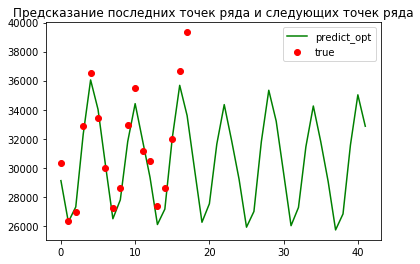

In [36]:
plt.plot(results_opt.forecast(42), "g", label="predict_opt")
plt.plot(data_m["PJME_MW"].values[-18:], "or", label="true")
plt.title("Предсказание последних точек ряда и следующих точек ряда")
plt.legend()

plt.show()

Получившаяся модель довольно точно описывает поведение временного ряда. Это также можно увидеть показателю AIC:
3040.5 для помесячной модели и 8657.9 для понедельной.

### Задание 4

Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках ) 

***Решение***

In [78]:
covid = (
    pd.read_csv("covid_19_data.csv", index_col=[0], parse_dates=[1, 4])
    .loc[lambda df: df["Country/Region"] == "Netherlands", :]
    .sort_values("ObservationDate")
)
display(covid.head(3))
covid.info()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
2569,2020-02-27,NaN,Netherlands,2020-02-27 21:13:10,1.0,0.0,0.0
2682,2020-02-28,NaN,Netherlands,2020-02-28 01:23:03,1.0,0.0,0.0
2761,2020-02-29,NaN,Netherlands,2020-02-29 18:03:05,6.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 2569 to 21842
Data columns (total 7 columns):
ObservationDate    250 non-null datetime64[ns]
Province/State     187 non-null object
Country/Region     250 non-null object
Last Update        250 non-null datetime64[ns]
Confirmed          250 non-null float64
Deaths             250 non-null float64
Recovered          250 non-null float64
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 15.6+ KB


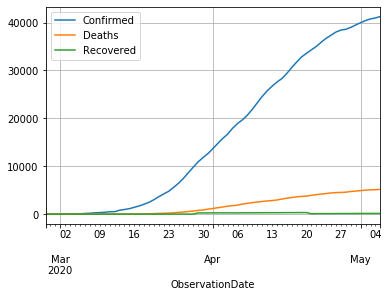

In [77]:
covid_d = (
    covid.groupby("ObservationDate")[["Confirmed", "Deaths", "Recovered"]]
    .sum()
    .sort_index()
)

covid_d.plot()
plt.legend()
plt.grid()
plt.show()

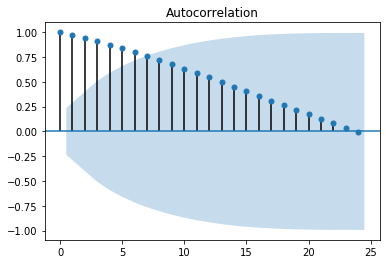

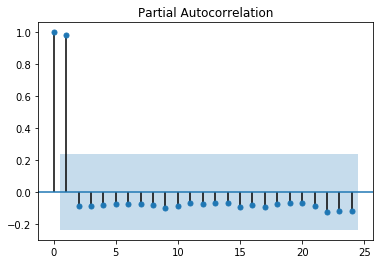

In [79]:
sm.graphics.tsa.plot_acf(covid_d.Confirmed.values, lags=12 * 2)
plt.show()

sm.graphics.tsa.plot_pacf(covid_d.Confirmed.values, lags=12 * 2)
plt.show()

In [80]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

In [83]:
%%time

min_aic = None
arima_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                covid_d.Confirmed.values,
                order=param,
                seasonal_order=[0, 0, 0, 0],
                enforce_stationarity=False,
                enforce_invertibility=False,
            )

            results = mod.fit()
            if not min_aic or min_aic > results.aic:
                min_aic = results.aic
                arima_params = "ARIMA{} - AIC: {}".format(param, results.aic)
        except:
            continue

print("*" * 20)
print(arima_params)

********************
ARIMA(2, 2, 2) - AIC: 813.8485729730085
CPU times: user 15.3 s, sys: 205 ms, total: 15.5 s
Wall time: 15.7 s


In [84]:
mod = sm.tsa.statespace.SARIMAX(
    covid_d.Confirmed.values[:-14],
    order=[2, 2, 2],
    seasonal_order=[0, 0, 0, 0],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results_opt = mod.fit()
print(f"AIC: {results_opt.aic}")

AIC: 636.6690101201109


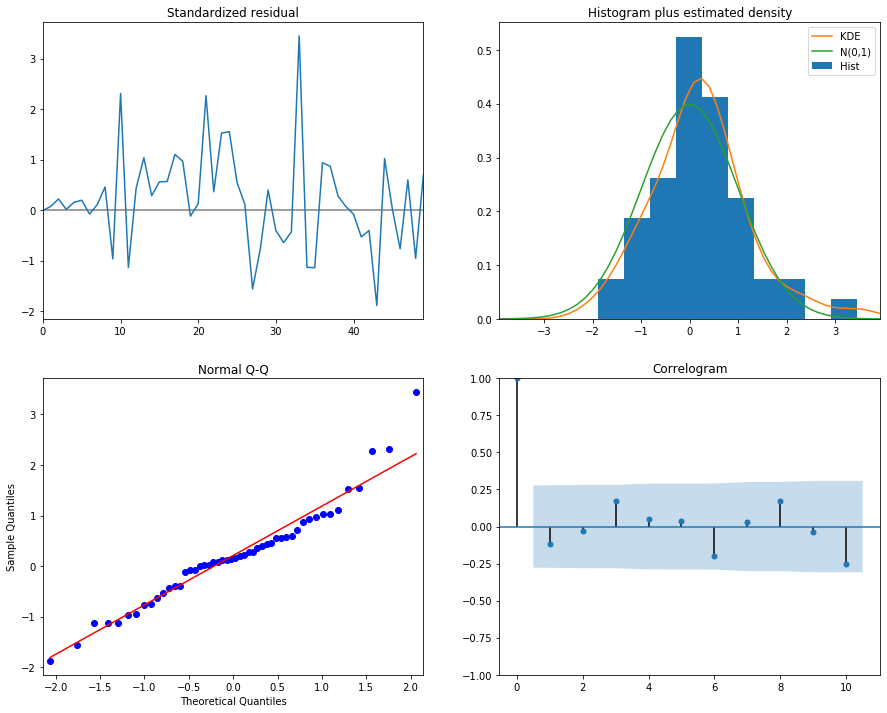

In [85]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()

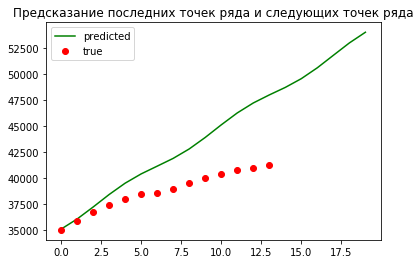

In [90]:
plt.plot(results_opt.forecast(20), "g", label="predicted")
plt.plot(covid_d.Confirmed.values[-14:], "or", label="true")
plt.title("Предсказание последних точек ряда и следующих точек ряда")
plt.legend()

plt.show()

### Задание 5

Оцените результат моделирования

***Решение***

ARIMA предсказала дальнейший рост заболеваемости, но не смогла определить, что данные имеют параболическую кривую и приближаются к своему экстремуму. 